### Zillow Prize: Zillow’s Home Value Prediction (Zestimate)
- Can you improve the algorithm that changed the world of real estate?

- Data Description
 - In this competition, Zillow is asking you to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. The log error is defined as
 `logerror=log(Zestimate)−log(SalePrice)`
 - and it is recorded in the transactions file train.csv. In this competition, you are going to predict the logerror for the months in Fall 2017. Since all the real estate transactions in the U.S. are publicly available, we will close the competition (no longer accepting submissions) before the evaluation period begins.
 
- You are asked to predict 6 time points for all properties: `October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).`

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
import xlrd
import openpyxl

### 1. 데이터 입력

In [2]:
data_dict = pd.read_excel('zillow_data_dictionary.xlsx', 'Data Dictionary')
data_dict.tail()

,Feature,Description
53,landtaxvaluedollarcnt',The assessed value of the land area of the parcel
54,taxamount',The total property tax assessed for that asses...
55,assessmentyear',The year of the property tax assessment
56,taxdelinquencyflag',Property taxes for this parcel are past due as...
57,taxdelinquencyyear',Year for which the unpaid propert taxes were due


In [3]:
train16 = pd.read_csv('train_2016_v2.csv', parse_dates=["transactiondate"])
train16.tail()

,parcelid,logerror,transactiondate
90270,10774160,-0.0356,2016-12-30
90271,12046695,0.0070,2016-12-30
90272,12995401,-0.2679,2016-12-30
90273,11402105,0.0602,2016-12-30
90274,12566293,0.4207,2016-12-30


In [4]:
train17 = pd.read_csv('train_2017.csv', parse_dates=["transactiondate"])
train17.tail()

,parcelid,logerror,transactiondate
77608,10833991,-0.002245,2017-09-20
77609,11000655,0.020615,2017-09-20
77610,17239384,0.013209,2017-09-21
77611,12773139,0.037129,2017-09-21
77612,12826780,0.007204,2017-09-25


In [5]:
prop16 = pd.read_csv('properties_2016.csv')
prop16.tail()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985216,168040430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
prop17 = pd.read_csv('properties_2017.csv')
prop17.tail()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
2985212,12170430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,11422430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,17203030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,14242830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985216,12766630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
merged16 = pd.merge(train16, prop16, on="parcelid", how="left")
merged16.tail()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
90270,10774160,-0.0356,2016-12-30,1.0,NaN,NaN,1.0,1.0,NaN,4.0,...,NaN,NaN,43800.0,191000.0,2015.0,147200.0,2495.24,NaN,NaN,6.037132e+13
90271,12046695,0.0070,2016-12-30,NaN,NaN,NaN,3.0,3.0,NaN,4.0,...,NaN,NaN,117893.0,161111.0,2015.0,43218.0,1886.54,NaN,NaN,6.037301e+13
90272,12995401,-0.2679,2016-12-30,NaN,NaN,NaN,2.0,4.0,NaN,7.0,...,NaN,NaN,22008.0,38096.0,2015.0,16088.0,1925.70,Y,14.0,6.037433e+13
90273,11402105,0.0602,2016-12-30,NaN,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,132991.0,165869.0,2015.0,32878.0,2285.57,NaN,NaN,6.037601e+13
90274,12566293,0.4207,2016-12-30,NaN,NaN,NaN,1.0,3.0,NaN,7.0,...,NaN,NaN,66258.0,163037.0,2015.0,96779.0,2560.96,NaN,NaN,6.037544e+13


In [8]:
merged17 = pd.merge(train17, prop17, on="parcelid", how="left")
merged17.tail()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
77608,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13
77609,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13
77610,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13
77611,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13
77612,12826780,0.007204,2017-09-25,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,NaN,NaN,140000.0,522000.0,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13


In [9]:
merged = pd.concat([merged16, merged17]).reset_index(drop=True)
merged.tail()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
167883,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13
167884,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13
167885,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13
167886,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13
167887,12826780,0.007204,2017-09-25,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,NaN,NaN,140000.0,522000.0,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13


In [10]:
print("shape of merged: ", merged.shape)

shape of merged:  (167888, 60)


##### comment
- data merge 결과 2016년&2017년의 167,888건의 거래에 대해 parcelid 포함 60개 변수를 가진 data가 만들어짐
- 변수: logerror, 거래날짜, properties data(해당 거래 년도의 data)

In [11]:
merged_des = merged.describe(include='all').transpose()
merged_des.reset_index()

,index,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
0,parcelid,167888,NaN,NaN,NaN,NaN,NaN,1.29954e+07,3.01607e+06,1.07117e+07,1.1549e+07,1.25406e+07,1.42193e+07,1.67689e+08
1,logerror,167888,NaN,NaN,NaN,NaN,NaN,0.0139063,0.165706,-4.65542,-0.0253,0.006,0.0392,5.263
2,transactiondate,167888,616,2017-06-30 00:00:00,1195,2016-01-01 00:00:00,2017-09-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,airconditioningtypeid,53788,NaN,NaN,NaN,NaN,NaN,1.81435,2.97024,1,1,1,1,13
4,architecturalstyletypeid,468,NaN,NaN,NaN,NaN,NaN,7.29915,2.71963,2,7,7,7,21
5,basementsqft,93,NaN,NaN,NaN,NaN,NaN,695.376,583.952,38,280,588,819,3560
6,bathroomcnt,167854,NaN,NaN,NaN,NaN,NaN,2.28827,1.00084,0,2,2,3,20
7,bedroomcnt,167854,NaN,NaN,NaN,NaN,NaN,3.04174,1.14913,0,2,3,4,16
8,buildingclasstypeid,31,NaN,NaN,NaN,NaN,NaN,3.96774,0.179605,3,4,4,4,4
9,buildingqualitytypeid,107173,NaN,NaN,NaN,NaN,NaN,6.01546,1.8828,1,4,7,7,12


- transaction된 부동산 parcel id가 unique한 값들의이 몇 개인지, 2번이나 3번 거래 된 것들은 몇 개인지

In [12]:
count = pd.DataFrame(columns=['count_all', 'count_2016', 'count_2017'])
count['count_all'] = (merged['parcelid'].value_counts().reset_index())['parcelid'].value_counts()
count['count_2016'] = (train16['parcelid'].value_counts().reset_index())['parcelid'].value_counts()
count['count_2017'] = (train17['parcelid'].value_counts().reset_index())['parcelid'].value_counts()
count

,count_all,count_2016,count_2017
1,162541,90026,77218
2,2660,123,193
3,9,1,3


In [13]:
merged_des["missing_ratio"] = 1-(merged_des["count"]/merged.shape[0])
merged_missing = pd.DataFrame(merged_des["missing_ratio"].sort_values(ascending=False))
merged_missing.reset_index()

,index,missing_ratio
0,buildingclasstypeid,0.999815
1,finishedsquarefeet13,0.999553
2,basementsqft,0.999446
3,storytypeid,0.999446
4,yardbuildingsqft26,0.999017
5,fireplaceflag,0.997653
6,architecturalstyletypeid,0.997212
7,typeconstructiontypeid,0.996891
8,finishedsquarefeet6,0.995193
9,decktypeid,0.992424


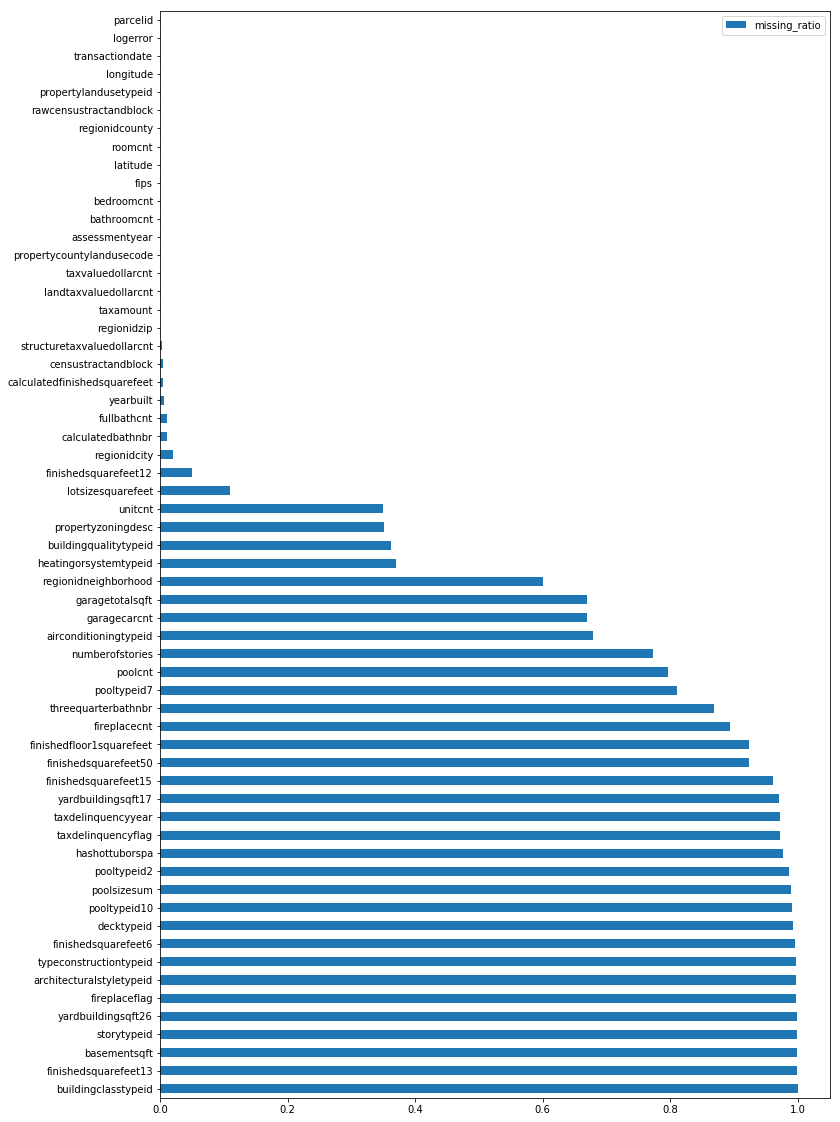

In [14]:
merged_missing.sort_values(by="missing_ratio", ascending=False).plot(kind='barh', figsize=(12,20))

##### * 욕실 관련 변수 : bathroomcnt, fullbathcnt, calculatebathnbr, threequarterbathnbr

In [15]:
bathroomcnt = pd.DataFrame(merged["bathroomcnt"])
bathroomcnt.groupby("bathroomcnt").size().reset_index(name='counts')

,bathroomcnt,counts
0,0.0,1764
1,1.0,27980
2,1.5,3060
3,2.0,68109
4,2.5,14698
5,3.0,37300
6,3.5,2127
7,4.0,7099
8,4.5,1491
9,5.0,2168


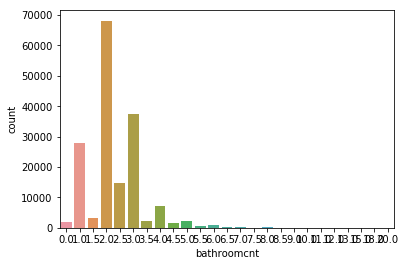

In [93]:
sns.countplot(x="bathroomcnt", data=bathroomcnt)
plt.show()

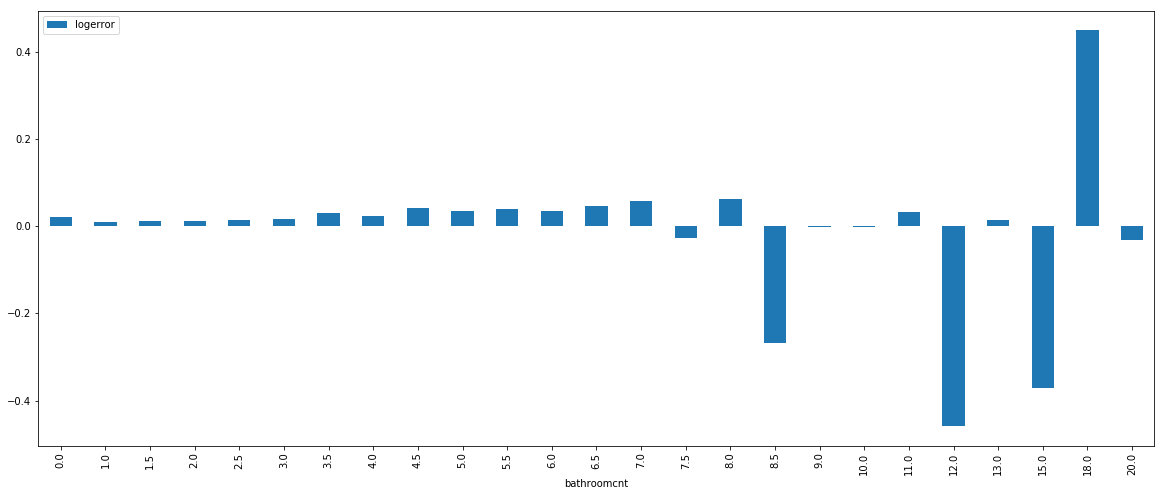

In [99]:
bathroomcnt_logerror = merged.loc[:,["bathroomcnt","logerror"]].groupby("bathroomcnt").agg('mean')
bathroomcnt_logerror.plot(kind = 'bar', figsize=(20, 8))

### *** bathroomcnt 변수와 나머지 3 변수간의 상관관계 분석**

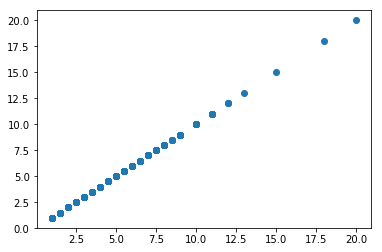

In [32]:
plt.scatter(bathroomcnt, calculatedbathnbr)
plt.show()

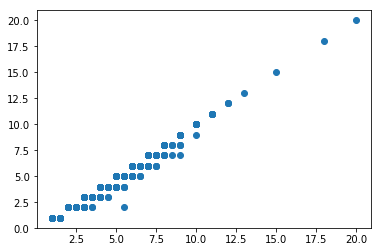

In [33]:
plt.scatter(bathroomcnt, fullbathcnt)
plt.show()

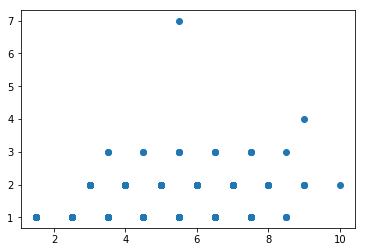

In [37]:
plt.scatter(bathroomcnt, threequarterbathnbr)
plt.show()
# 상관관계 불분명, threequarterbathnbr의 데이터 갯수가 부족함
# -> 따로 쓰든지, 아예 빼든지 둘 중 하나

In [17]:
merged_des.loc["bathroomcnt"].transpose()

count                 167854
unique                   NaN
top                      NaN
freq                     NaN
first                    NaN
last                     NaN
mean                 2.28827
std                  1.00084
min                        0
25%                        2
50%                        2
75%                        3
max                       20
missing_ratio    0.000202516
Name: bathroomcnt, dtype: object

In [18]:
fullbathcnt = pd.DataFrame(merged["fullbathcnt"])
fullbathcnt.groupby("fullbathcnt").size().reset_index(name='counts')

,fullbathcnt,counts
0,1.0,31028
1,2.0,82825
2,3.0,39429
3,4.0,8594
4,5.0,2637
5,6.0,946
6,7.0,285
7,8.0,223
8,9.0,56
9,10.0,20


In [19]:
merged_des.loc["fullbathcnt"].transpose()

count              166056
unique                NaN
top                   NaN
freq                  NaN
first                 NaN
last                  NaN
mean              2.24534
std              0.964703
min                     1
25%                     2
50%                     2
75%                     3
max                    20
missing_ratio    0.010912
Name: fullbathcnt, dtype: object

In [20]:
calculatedbathnbr = pd.DataFrame(merged["calculatedbathnbr"])
calculatedbathnbr.groupby("calculatedbathnbr").size().reset_index(name='counts')

,calculatedbathnbr,counts
0,1.0,27980
1,1.5,3048
2,2.0,68109
3,2.5,14682
4,3.0,37300
5,3.5,2124
6,4.0,7099
7,4.5,1489
8,5.0,2168
9,5.5,476


In [23]:
merged_des.loc["calculatedbathnbr"].transpose()

count              166056
unique                NaN
top                   NaN
freq                  NaN
first                 NaN
last                  NaN
mean              2.31254
std              0.977808
min                     1
25%                     2
50%                     2
75%                     3
max                    20
missing_ratio    0.010912
Name: calculatedbathnbr, dtype: object

In [24]:
threequarterbathnbr = pd.DataFrame(merged["threequarterbathnbr"])
threequarterbathnbr.groupby("threequarterbathnbr").size().reset_index(name='counts')

,threequarterbathnbr,counts
0,1.0,21934
1,2.0,165
2,3.0,14
3,4.0,1
4,7.0,1


In [25]:
merged_des.loc["threequarterbathnbr"].transpose()

count               22115
unique                NaN
top                   NaN
freq                  NaN
first                 NaN
last                  NaN
mean              1.00913
std              0.109294
min                     1
25%                     1
50%                     1
75%                     1
max                     7
missing_ratio    0.868275
Name: threequarterbathnbr, dtype: object

##### * 결론 :
- bathroomcnt와 fullbathcnt, calculatedbathnbr는 거의 비슷한 분포를 보인다.
- 셋 중 하나를 쓰고, threequarterbathnbr는 쓰지 않는게 좋겠다.

In [50]:
numberofstories = pd.DataFrame(merged["numberofstories"])
numberofstories.groupby("numberofstories").size().reset_index(name='counts')

,numberofstories,counts
0,1.0,22413
1,2.0,14808
2,3.0,945
3,4.0,2
4,6.0,1


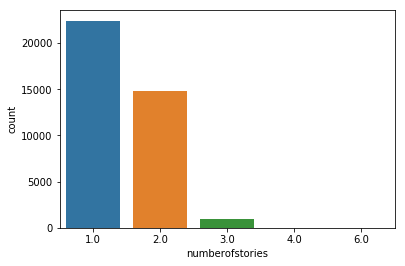

In [55]:
sns.countplot(x="numberofstories", data=numberofstories)
plt.show()

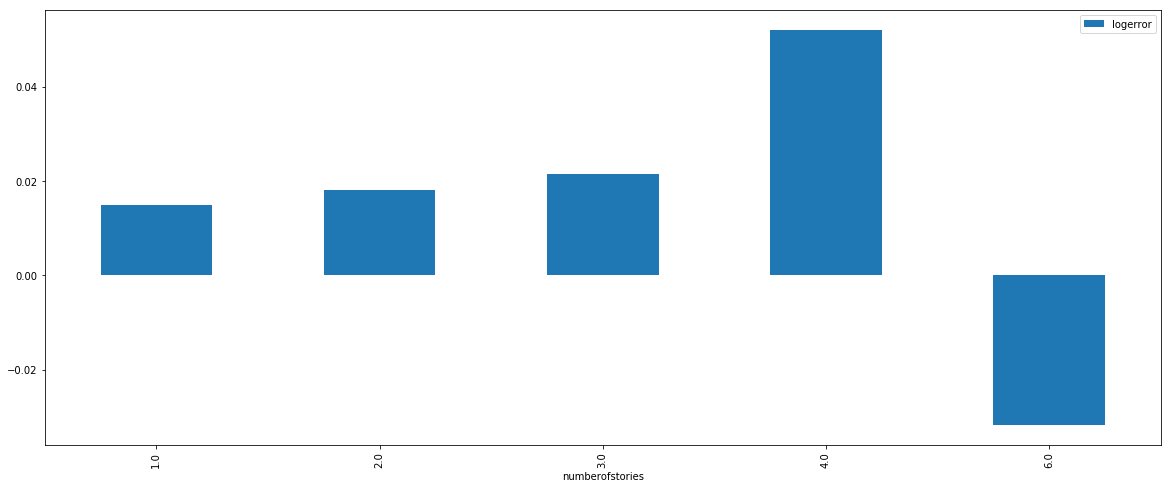

In [100]:
numberofstories_logerror = merged.loc[:,["numberofstories","logerror"]].groupby("numberofstories").agg('mean')
numberofstories_logerror.plot(kind = 'bar', figsize=(20, 8))

In [43]:
merged_des.loc["numberofstories"].transpose()

count               38169
unique                NaN
top                   NaN
freq                  NaN
first                 NaN
last                  NaN
mean              1.43776
std              0.544508
min                     1
25%                     1
50%                     1
75%                     2
max                     6
missing_ratio    0.772652
Name: numberofstories, dtype: object

In [40]:
roomcnt = pd.DataFrame(merged["roomcnt"])
roomcnt.groupby("roomcnt").size().reset_index(name='counts')

,roomcnt,counts
0,0.0,129666
1,1.0,4
2,2.0,25
3,3.0,483
4,4.0,3096
5,5.0,6509
6,6.0,9876
7,7.0,8332
8,8.0,6285
9,9.0,2552


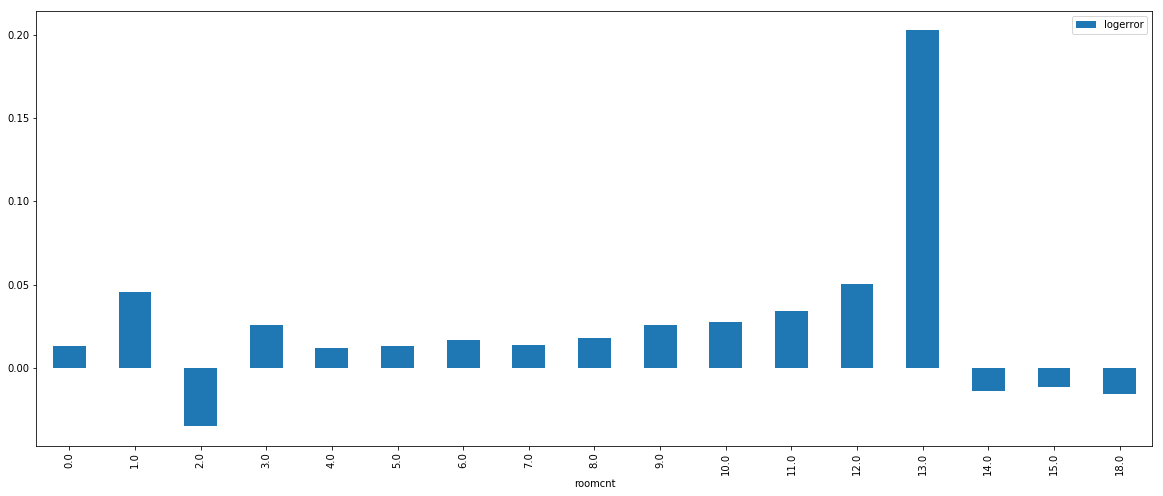

In [101]:
roomcnt_logerror = merged.loc[:,["roomcnt","logerror"]].groupby("roomcnt").agg('mean')
roomcnt_logerror.plot(kind = 'bar', figsize=(20, 8))

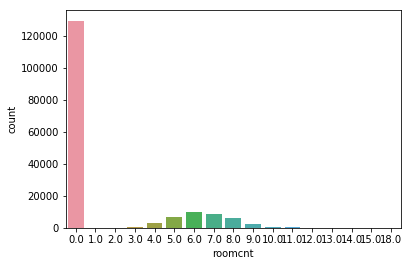

In [56]:
sns.countplot(x="roomcnt", data=roomcnt)
plt.show()

In [41]:
merged_des.loc["roomcnt"].transpose()

count                 167854
unique                   NaN
top                      NaN
freq                     NaN
first                    NaN
last                     NaN
mean                 1.47748
std                   2.8215
min                        0
25%                        0
50%                        0
75%                        0
max                       18
missing_ratio    0.000202516
Name: roomcnt, dtype: object

### *** 잠깐 : 왜 때문에 0개의 방이 제일 많은거지...?**
 - Total number of rooms in the principal residence : 주거주 총 객실 수
 - 게다가 1, 2개 방 수가 지나치게 적다.
 - bedroomcnt 변수로 사용하는게 나을듯

In [ ]:
basementsqft = pd.DataFrame(merged["basementsqft"])
basementsqft.groupby("basementsqft").size().reset_index(name='counts')

In [ ]:
merged_des.loc["basementsqft"].transpose()

### *** 버려도 되는 값입니다. 숫자가 지나치게 적습니다. **

In [57]:
bedroomcnt = pd.DataFrame(merged["bedroomcnt"])
bedroomcnt.groupby("bedroomcnt").size().reset_index(name='counts')

,bedroomcnt,counts
0,0.0,2258
1,1.0,7288
2,2.0,41580
3,3.0,65883
4,4.0,37830
5,5.0,9627
6,6.0,2120
7,7.0,442
8,8.0,527
9,9.0,161


In [58]:
merged_des.loc["bedroomcnt"].transpose()

count                 167854
unique                   NaN
top                      NaN
freq                     NaN
first                    NaN
last                     NaN
mean                 3.04174
std                  1.14913
min                        0
25%                        2
50%                        3
75%                        4
max                       16
missing_ratio    0.000202516
Name: bedroomcnt, dtype: object

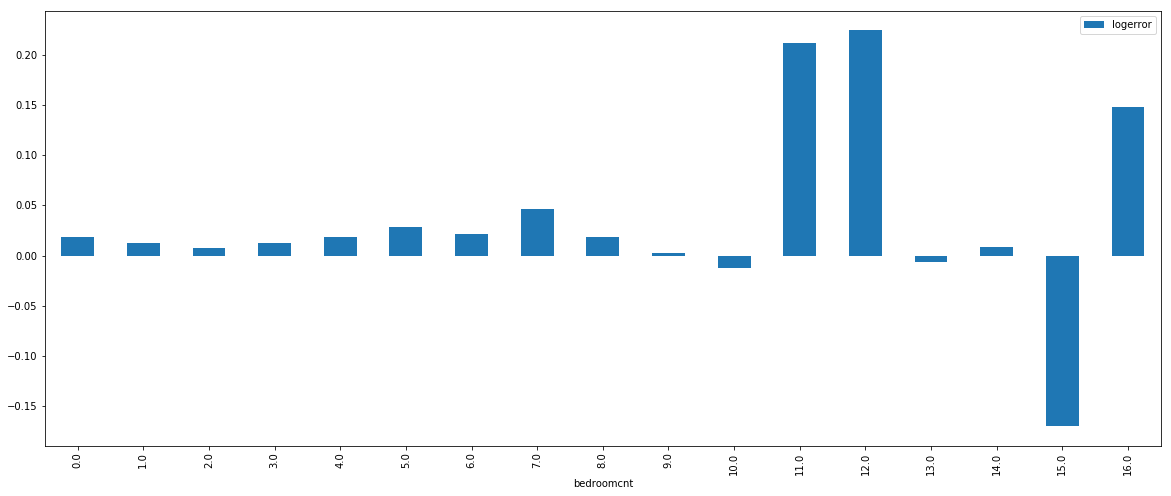

In [102]:
bedroomcnt_logerror = merged.loc[:,["bedroomcnt","logerror"]].groupby("bedroomcnt").agg('mean')
bedroomcnt_logerror.plot(kind = 'bar', figsize=(20, 8))

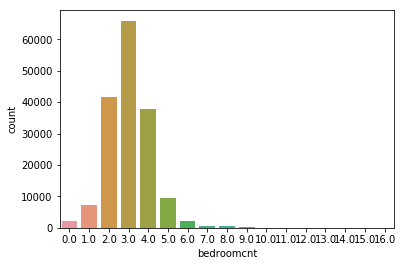

In [59]:
sns.countplot(x="bedroomcnt", data=bedroomcnt)
plt.show()

In [60]:
unitcnt = pd.DataFrame(merged["unitcnt"])
unitcnt.groupby("unitcnt").size().reset_index(name='counts')

,unitcnt,counts
0,1.0,101916
1,2.0,4385
2,3.0,1148
3,4.0,1597
4,5.0,1
5,6.0,2
6,9.0,1
7,11.0,1
8,42.0,1
9,45.0,1


In [61]:
merged_des.loc["unitcnt"].transpose()

count              109056
unique                NaN
top                   NaN
freq                  NaN
first                 NaN
last                  NaN
mean              1.11037
std              0.988168
min                     1
25%                     1
50%                     1
75%                     1
max                   237
missing_ratio    0.350424
Name: unitcnt, dtype: object

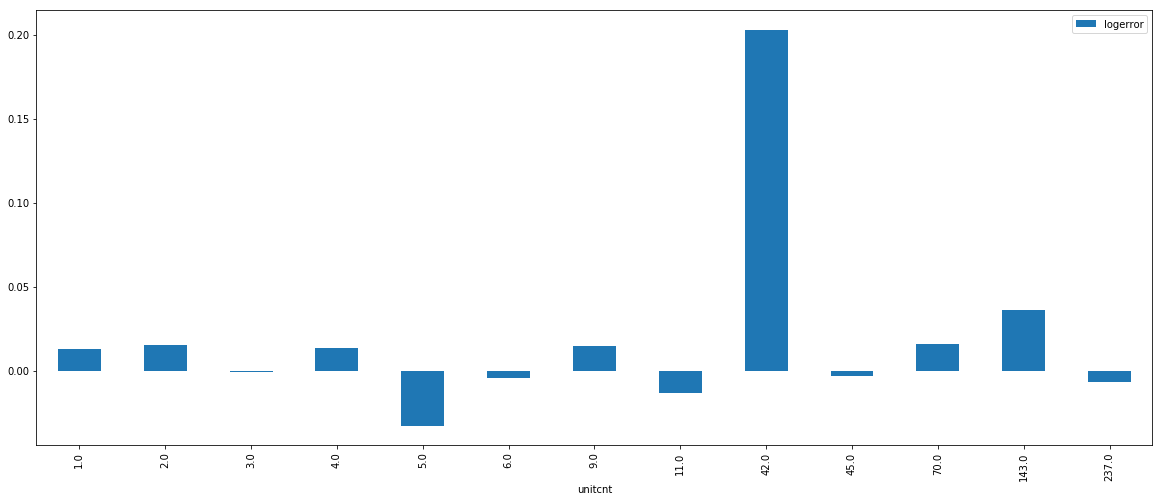

In [103]:
unitcnt_logerror = merged.loc[:,["unitcnt","logerror"]].groupby("unitcnt").agg('mean')
unitcnt_logerror.plot(kind = 'bar', figsize=(20, 8))

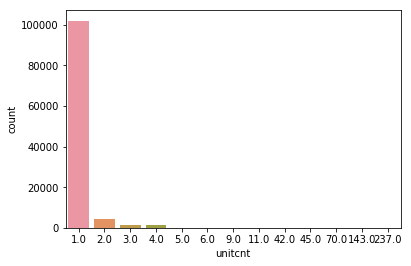

In [62]:
sns.countplot(x="unitcnt", data=unitcnt)
plt.show()

- 거주용 부동산은 **duplex, triplex,** APT 등등 장기거주에 사용되는 건물
 - 미국 부동산에서 단독주택의 범주에 들어가는 것이 있습니다.
 - 1. 흔히 말하는 진짜 단독주택: 단독주택, 타운홈, 콘도등 한가족이 살 수 있는 집
 - 2. Duplex: 두채가 있는 집. 예를 들면, 주인이 본 채에서 살고 한 채는 세를 놓을 수 있는 집
 - 3. Triplex: 세 채가 있는 집. 위에서 설명한 바와 같이 본 채 하나에 두집이 더 살 수 있는 집을 말합니다.
 - 4. Fourplex: 네 채가 있는 집
 - Triplex는 세(3)집이 한 건물에 붙어있는 것(두 집이 한 건물에 붙어 있으면 Duplex)
 - Triplex는 세(3)집이 한 건물에 붙어있지만 세 가구가 살수있도록 모든것이 다 따로 있습니다.

### *** 굉장히 중요한 의미를 가지고 있습니다!**

In [63]:
yearbuilt = pd.DataFrame(merged["yearbuilt"])
yearbuilt.groupby("yearbuilt").size().reset_index(name='counts')

,yearbuilt,counts
0,1824.0,1
1,1866.0,1
2,1878.0,1
3,1880.0,1
4,1882.0,1
5,1883.0,1
6,1885.0,12
7,1886.0,1
8,1887.0,4
9,1888.0,6


In [64]:
merged_des.loc["yearbuilt"].transpose()

count                166828
unique                  NaN
top                     NaN
freq                    NaN
first                   NaN
last                    NaN
mean                1968.57
std                 23.7772
min                    1824
25%                    1953
50%                    1970
75%                    1987
max                    2016
missing_ratio    0.00631373
Name: yearbuilt, dtype: object

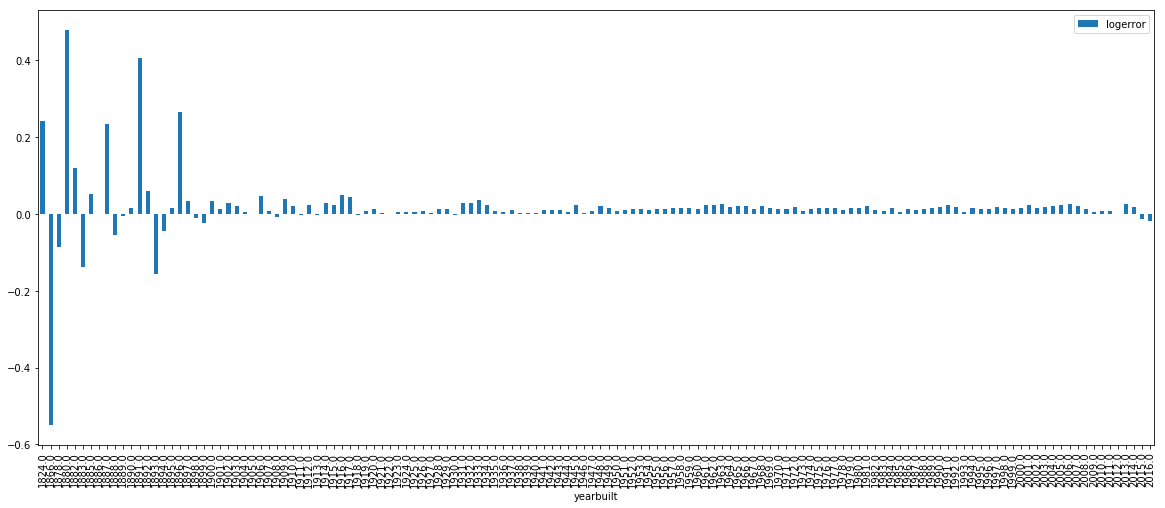

In [104]:
yearbuilt_logerror = merged.loc[:,["yearbuilt","logerror"]].groupby("yearbuilt").agg('mean')
yearbuilt_logerror.plot(kind = 'bar', figsize=(20, 8))

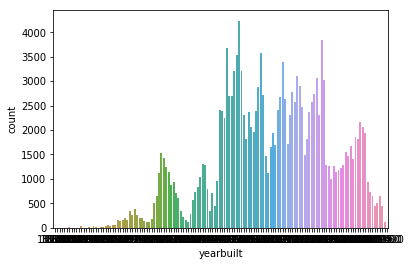

In [66]:
sns.countplot(x="yearbuilt", data=yearbuilt)
plt.show()

### *** 연도별로 각각 나눌 것이 아니라 10년 단위로 끊어주면 분류가 편할 듯**

In [70]:
heatingorsystemtypeid = pd.DataFrame(merged["heatingorsystemtypeid"])
heatingorsystemtypeid.groupby("heatingorsystemtypeid").size().reset_index(name='counts')

,heatingorsystemtypeid,counts
0,1.0,26
1,2.0,71936
2,6.0,1747
3,7.0,29626
4,10.0,5
5,11.0,2
6,12.0,1
7,13.0,136
8,14.0,2
9,18.0,48


- 1	Baseboard
- 2	Central
- 6	Forced air
- 7	Floor/Wall
- 10	Gravity
- 11	Heat Pump
- 12	Hot Water
- 13	None
- 14	Other
- 18	Radiant
- 20	Solar
- 24	Yes

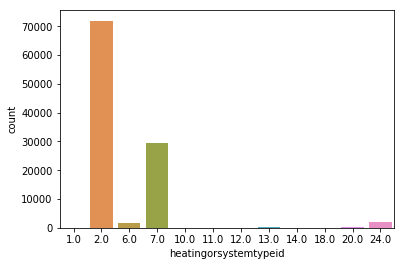

In [108]:
sns.countplot(x="heatingorsystemtypeid", data=heatingorsystemtypeid)
plt.show()

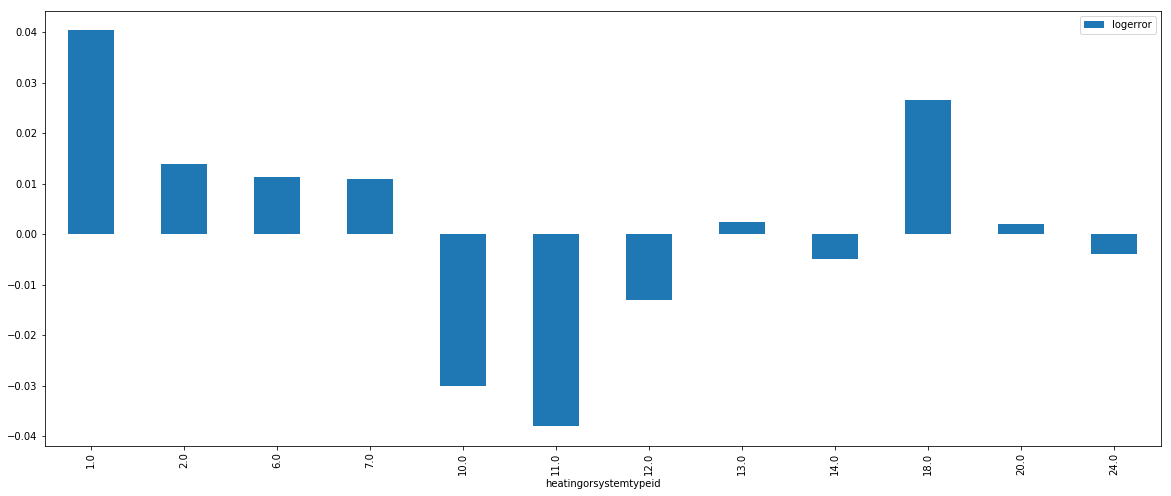

In [105]:
heatingorsystemtypeid_logerror = merged.loc[:,["heatingorsystemtypeid","logerror"]].groupby("heatingorsystemtypeid").agg('mean')
heatingorsystemtypeid_logerror.plot(kind = 'bar', figsize=(20, 8))

In [78]:
merged_des.loc["heatingorsystemtypeid"].transpose()

count              105651
unique                NaN
top                   NaN
freq                  NaN
first                 NaN
last                  NaN
mean              3.92453
std                3.6426
min                     1
25%                     2
50%                     2
75%                     7
max                    24
missing_ratio    0.370705
Name: heatingorsystemtypeid, dtype: object

In [79]:
airconditioningtypeid = pd.DataFrame(merged["airconditioningtypeid"])
airconditioningtypeid.groupby("airconditioningtypeid").size().reset_index(name='counts')

,airconditioningtypeid,counts
0,1.0,49854
1,3.0,1
2,5.0,382
3,9.0,27
4,11.0,116
5,13.0,3408


- 1	Central
- 3	Evaporative Cooler
- 5	None
- 9	Refrigeration
- 11 Wall Unit
- 13 Yes

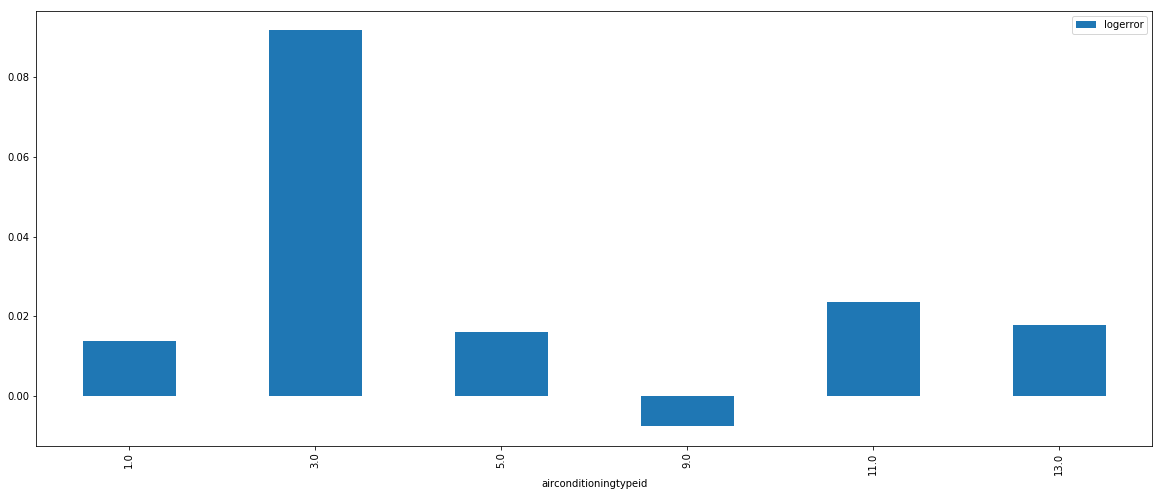

In [106]:
airconditioningtypeid_logerror = merged.loc[:,["airconditioningtypeid","logerror"]].groupby("airconditioningtypeid").agg('mean')
airconditioningtypeid_logerror.plot(kind = 'bar', figsize=(20, 8))

In [80]:
merged_des.loc["airconditioningtypeid"].transpose()

count              53788
unique               NaN
top                  NaN
freq                 NaN
first                NaN
last                 NaN
mean             1.81435
std              2.97024
min                    1
25%                    1
50%                    1
75%                    1
max                   13
missing_ratio    0.67962
Name: airconditioningtypeid, dtype: object

In [81]:
hashottuborspa = pd.DataFrame(merged["hashottuborspa"])
hashottuborspa.groupby("hashottuborspa").size().reset_index(name='counts')

,hashottuborspa,counts
0,True,3904


In [83]:
merged_des.loc["hashottuborspa"].transpose()

count                3904
unique                  1
top                  True
freq                 3904
first                 NaN
last                  NaN
mean                  NaN
std                   NaN
min                   NaN
25%                   NaN
50%                   NaN
75%                   NaN
max                   NaN
missing_ratio    0.976746
Name: hashottuborspa, dtype: object

### *** 버려**

In [84]:
fireplacecnt = pd.DataFrame(merged["fireplacecnt"])
fireplacecnt.groupby("fireplacecnt").size().reset_index(name='counts')

,fireplacecnt,counts
0,1.0,15183
1,2.0,2104
2,3.0,547
3,4.0,56
4,5.0,6


In [85]:
merged_des.loc["fireplacecnt"].transpose()

count               17896
unique                NaN
top                   NaN
freq                  NaN
first                 NaN
last                  NaN
mean              1.18943
std              0.487327
min                     1
25%                     1
50%                     1
75%                     1
max                     5
missing_ratio    0.893405
Name: fireplacecnt, dtype: object

### *** Missing Ratio가 너무 높다. 버리자.**

In [86]:
fireplaceflag = pd.DataFrame(merged["fireplaceflag"])
fireplaceflag.groupby("fireplaceflag").size().reset_index(name='counts')

,fireplaceflag,counts
0,True,394


### *** 버려.**

In [87]:
poolcnt = pd.DataFrame(merged["poolcnt"])
poolcnt.groupby("poolcnt").size().reset_index(name='counts')

,poolcnt,counts
0,1.0,34075


In [88]:
poolsizesum = pd.DataFrame(merged["poolsizesum"])
poolsizesum.groupby("poolsizesum").size().reset_index(name='counts')

,poolsizesum,counts
0,24.0,1
1,28.0,1
2,38.0,1
3,40.0,1
4,49.0,1
5,65.0,1
6,91.0,1
7,105.0,1
8,112.0,1
9,129.0,1


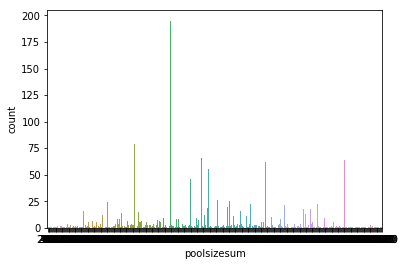

In [109]:
sns.countplot(x="poolsizesum", data=poolsizesum)
plt.show()

In [89]:
pooltypeid10 = pd.DataFrame(merged["pooltypeid10"])
pooltypeid10.groupby("pooltypeid10").size().reset_index(name='counts')

,pooltypeid10,counts
0,1.0,1626


In [90]:
pooltypeid2 = pd.DataFrame(merged["pooltypeid2"])
pooltypeid2.groupby("pooltypeid2").size().reset_index(name='counts')

,pooltypeid2,counts
0,1.0,2278


In [92]:
pooltypeid7 = pd.DataFrame(merged["pooltypeid7"])
pooltypeid7.groupby("pooltypeid7").size().reset_index(name='counts')

,pooltypeid7,counts
0,1.0,31776
